In [1]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image

### rnn

In [2]:
import numpy as np
dataset_path = "dataset/dataset_0725"

X_train = np.load(f'{dataset_path}/X_train.npy')
y_train = np.load(f'{dataset_path}/y_train.npy').astype(float).flatten()
X_val = np.load(f'{dataset_path}/X_val.npy')
y_val = np.load(f'{dataset_path}/y_val.npy').astype(float).flatten()
X_test = np.load(f'{dataset_path}/X_test.npy')
y_test = np.load(f'{dataset_path}/y_test.npy').astype(float).flatten()





# with lr list

In [9]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

# 假设 X_train, y_train, X_val, y_val, X_test, y_test 数据已经存在
seed = 42
random.seed(seed)
torch.manual_seed(seed)

# 将数据转换为 PyTorch 张量
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# 数据归一化
mean = X_train_tensor.mean(dim=0, keepdim=True)
std = X_train_tensor.std(dim=0, keepdim=True)
X_train_tensor = (X_train_tensor - mean) / std
X_val_tensor = (X_val_tensor - mean) / std
X_test_tensor = (X_test_tensor - mean) / std

# 创建数据加载器
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 定义 RNN 回归模型
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(RNNModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# 定义自定义的准确率函数
def calculate_custom_accuracy(predictions, targets, tolerance=0.1):
    predictions = predictions.detach().cpu().numpy()
    targets = targets.detach().cpu().numpy()
    correct = np.abs(predictions - targets) < tolerance
    accuracy = np.mean(correct)
    return accuracy

# learning_rates = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
learning_rates = [ 1e-3, 1e-4]
num_epochs = 10000

results = {}


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for lr in learning_rates:
    print(f"Training with learning rate: {lr}")
    model = RNNModel(input_dim=12, hidden_dim=128, output_dim=1, num_layers=2).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_accuracy = 0.0
    best_val_accuracy_epoch = 0
    lowest_val_loss = float('inf')
    lowest_val_loss_epoch = 0
    best_train_accuracy = 0.0
    best_train_accuracy_epoch = 0
    lowest_train_loss = float('inf')
    lowest_train_loss_epoch = 0

    for epoch in tqdm(range(num_epochs), desc=f"Learning Rate {lr}"):
        model.train()
        running_loss = 0.0
        all_predictions_train = []
        all_labels_train = []
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            inputs = inputs.unsqueeze(1)  # 调整维度为 (batch_size, seq_length, input_dim)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))  # 将标签调整为 (batch_size, 1)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            
            all_predictions_train.append(outputs)
            all_labels_train.append(labels.unsqueeze(1))
        
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        
        all_predictions_train = torch.cat(all_predictions_train, dim=0)
        all_labels_train = torch.cat(all_labels_train, dim=0)
        train_accuracy = calculate_custom_accuracy(all_predictions_train, all_labels_train, tolerance=1)
        train_accuracies.append(train_accuracy)
        
        model.eval()
        val_loss = 0.0
        val_accuracy = 0.0
        all_predictions = []
        all_labels = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                inputs = inputs.unsqueeze(1)  # 调整维度为 (batch_size, seq_length, input_dim)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels.unsqueeze(1))  # 将标签调整为 (batch_size, 1)
                val_loss += loss.item() * inputs.size(0)
                
                all_predictions.append(outputs)
                all_labels.append(labels.unsqueeze(1))
        
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        
        all_predictions = torch.cat(all_predictions, dim=0)
        all_labels = torch.cat(all_labels, dim=0)
        val_accuracy = calculate_custom_accuracy(all_predictions, all_labels, tolerance=0.1)
        val_accuracies.append(val_accuracy)
        
        # 记录最好的准确率和最低的损失
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_val_accuracy_epoch = epoch + 1
        if val_loss < lowest_val_loss:
            lowest_val_loss = val_loss
            lowest_val_loss_epoch = epoch + 1
        if train_accuracy > best_train_accuracy:
            best_train_accuracy = train_accuracy
            best_train_accuracy_epoch = epoch + 1
        if epoch_loss < lowest_train_loss:
            lowest_train_loss = epoch_loss
            lowest_train_loss_epoch = epoch + 1
    
    results[lr] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'best_val_accuracy': best_val_accuracy,
        'best_val_accuracy_epoch': best_val_accuracy_epoch,
        'lowest_val_loss': lowest_val_loss,
        'lowest_val_loss_epoch': lowest_val_loss_epoch,
        'best_train_accuracy': best_train_accuracy,
        'best_train_accuracy_epoch': best_train_accuracy_epoch,
        'lowest_train_loss': lowest_train_loss,
        'lowest_train_loss_epoch': lowest_train_loss_epoch,
    }



# 打印每个学习率的最佳结果



Training with learning rate: 0.001


Learning Rate 0.001:   0%|          | 0/10000 [00:00<?, ?it/s]

Learning Rate 0.001: 100%|██████████| 10000/10000 [3:33:36<00:00,  1.28s/it] 


Training with learning rate: 0.0001


Learning Rate 0.0001: 100%|██████████| 10000/10000 [4:57:46<00:00,  1.79s/it] 


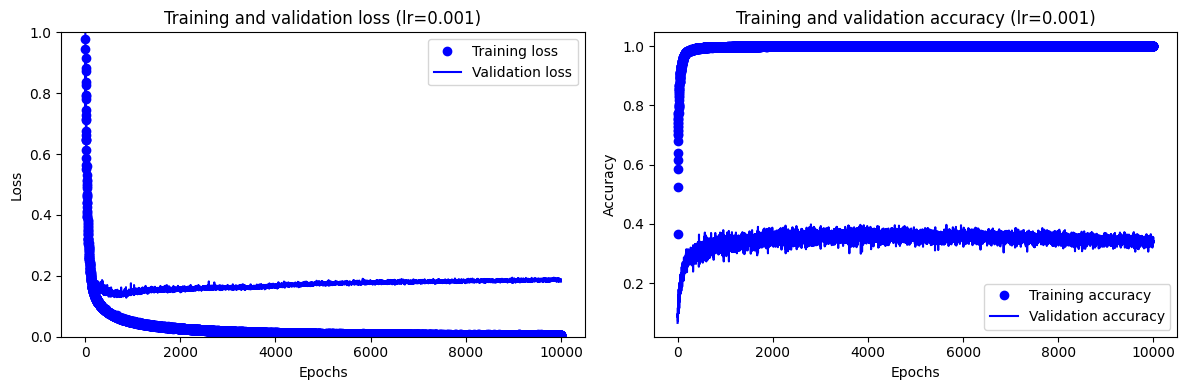

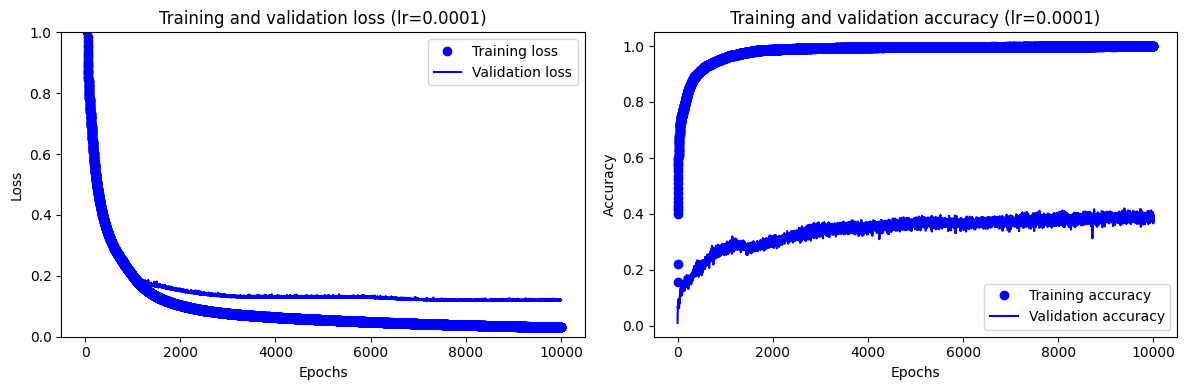

In [10]:
# 绘制图表
for lr, result in results.items():
    epochs = range(1, num_epochs + 1)
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, result['train_losses'], 'bo', label='Training loss')
    plt.plot(epochs, result['val_losses'], 'b', label='Validation loss')
    plt.title(f'Training and validation loss (lr={lr})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0, 1.0)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, result['train_accuracies'], 'bo', label='Training accuracy')
    plt.plot(epochs, result['val_accuracies'], 'b', label='Validation accuracy')
    plt.title(f'Training and validation accuracy (lr={lr})')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [11]:
for lr, result in results.items():
    print(f"Learning rate: {lr}")
    print(f"Best Validation Accuracy: {result['best_val_accuracy']:.4f} at epoch {result['best_val_accuracy_epoch']}")
    print(f"Lowest Validation Loss: {result['lowest_val_loss']:.4f} at epoch {result['lowest_val_loss_epoch']}")
    print(f"Best Training Accuracy: {result['best_train_accuracy']:.4f} at epoch {result['best_train_accuracy_epoch']}")
    print(f"Lowest Training Loss: {result['lowest_train_loss']:.4f} at epoch {result['lowest_train_loss_epoch']}")
    print("\n")

Learning rate: 0.001
Best Validation Accuracy: 0.3984 at epoch 2803
Lowest Validation Loss: 0.1282 at epoch 867
Best Training Accuracy: 1.0000 at epoch 2124
Lowest Training Loss: 0.0038 at epoch 9915


Learning rate: 0.0001
Best Validation Accuracy: 0.4190 at epoch 9390
Lowest Validation Loss: 0.1169 at epoch 8571
Best Training Accuracy: 0.9997 at epoch 9740
Lowest Training Loss: 0.0304 at epoch 9997




# only 1 lr

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import random

# 假设 X_train, y_train, X_val, y_val, X_test, y_test 数据已经存在
seed = 42
random.seed(seed)
torch.manual_seed(seed)

lr_list = []
# 将数据转换为 PyTorch 张量

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# 数据归一化
mean = X_train_tensor.mean(dim=0, keepdim=True)
std = X_train_tensor.std(dim=0, keepdim=True)
X_train_tensor = (X_train_tensor - mean) / std
X_val_tensor = (X_val_tensor - mean) / std
X_test_tensor = (X_test_tensor - mean) / std

# 创建数据加载器
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 定义 RNN 回归模型
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(RNNModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

input_dim = 12
hidden_dim = 128
output_dim = 1  
num_layers = 2

model = RNNModel(input_dim, hidden_dim, output_dim, num_layers)

# 损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)#0.001

# 记录损失和评价指标
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_accuracy = 0.0
best_val_accuracy_epoch = 0
lowest_val_loss = float('inf')
lowest_val_loss_epoch = 0
best_train_accuracy = 0.0
best_train_accuracy_epoch = 0
lowest_train_loss = float('inf')
lowest_train_loss_epoch = 0

# 训练模型
num_epochs = 2000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 定义自定义的准确率函数
def calculate_custom_accuracy(predictions, targets, tolerance=0.1):
    predictions = predictions.detach().cpu().numpy()
    targets = targets.detach().cpu().numpy()
    correct = np.abs(predictions - targets) < tolerance
    accuracy = np.mean(correct)
    return accuracy

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    all_predictions_train = []
    all_labels_train = []
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        inputs = inputs.unsqueeze(1)  # 调整维度为 (batch_size, seq_length, input_dim)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))  # 将标签调整为 (batch_size, 1)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        
        all_predictions_train.append(outputs)
        all_labels_train.append(labels.unsqueeze(1))
    
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    
    all_predictions_train = torch.cat(all_predictions_train, dim=0)
    all_labels_train = torch.cat(all_labels_train, dim=0)
    train_accuracy = calculate_custom_accuracy(all_predictions_train, all_labels_train, tolerance=1)
    train_accuracies.append(train_accuracy)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Training Accuracy: {train_accuracy:.4f}')
    
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            inputs = inputs.unsqueeze(1)  # 调整维度为 (batch_size, seq_length, input_dim)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))  # 将标签调整为 (batch_size, 1)
            val_loss += loss.item() * inputs.size(0)
            
            all_predictions.append(outputs)
            all_labels.append(labels.unsqueeze(1))
    
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    
    all_predictions = torch.cat(all_predictions, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    val_accuracy = calculate_custom_accuracy(all_predictions, all_labels, tolerance=0.1)
    val_accuracies.append(val_accuracy)
    
    print(f'Validation Loss: {val_loss:.4f}, Custom Accuracy: {val_accuracy:.4f}')
    
    # 记录最好的准确率和最低的损失
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_val_accuracy_epoch = epoch + 1
    if val_loss < lowest_val_loss:
        lowest_val_loss = val_loss
        lowest_val_loss_epoch = epoch + 1
    if train_accuracy > best_train_accuracy:
        best_train_accuracy = train_accuracy
        best_train_accuracy_epoch = epoch + 1
    if epoch_loss < lowest_train_loss:
        lowest_train_loss = epoch_loss
        lowest_train_loss_epoch = epoch + 1





Epoch [1/2000], Loss: 33.6152, Training Accuracy: 0.1546
Validation Loss: 19.8651, Custom Accuracy: 0.0082
Epoch [2/2000], Loss: 10.0632, Training Accuracy: 0.2168
Validation Loss: 3.7487, Custom Accuracy: 0.0591
Epoch [3/2000], Loss: 3.6676, Training Accuracy: 0.4003
Validation Loss: 2.9440, Custom Accuracy: 0.0440
Epoch [4/2000], Loss: 3.2852, Training Accuracy: 0.4120
Validation Loss: 2.7141, Custom Accuracy: 0.0618
Epoch [5/2000], Loss: 3.0772, Training Accuracy: 0.4223
Validation Loss: 2.5469, Custom Accuracy: 0.0632
Epoch [6/2000], Loss: 2.8977, Training Accuracy: 0.4298
Validation Loss: 2.4115, Custom Accuracy: 0.0618
Epoch [7/2000], Loss: 2.7557, Training Accuracy: 0.4341
Validation Loss: 2.3146, Custom Accuracy: 0.0797
Epoch [8/2000], Loss: 2.6182, Training Accuracy: 0.4534
Validation Loss: 2.2107, Custom Accuracy: 0.0783
Epoch [9/2000], Loss: 2.4885, Training Accuracy: 0.4650
Validation Loss: 2.1140, Custom Accuracy: 0.0865
Epoch [10/2000], Loss: 2.3676, Training Accuracy: 0.

KeyboardInterrupt: 

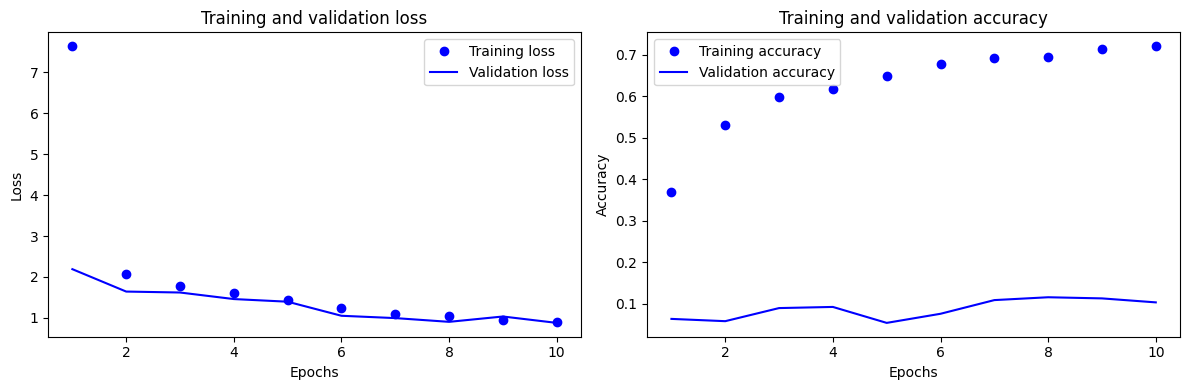

In [10]:

# 绘制损失和准确率图
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:

print(f'Best Training Accuracy: {best_train_accuracy:.4f} at epoch {best_train_accuracy_epoch}')
print(f'Lowest Training Loss: {lowest_train_loss:.4f} at epoch {lowest_train_loss_epoch}')
print(f'Best Validation Accuracy: {best_val_accuracy:.4f} at epoch {best_val_accuracy_epoch}')
print(f'Lowest Validation Loss: {lowest_val_loss:.4f} at epoch {lowest_val_loss_epoch}')

Best Training Accuracy: 0.7208 at epoch 10
Lowest Training Loss: 0.9027 at epoch 10
Best Validation Accuracy: 0.1154 at epoch 8
Lowest Validation Loss: 0.8772 at epoch 10


Best Training Accuracy: 0.7160 at epoch 10
Lowest Training Loss: 0.9155 at epoch 10
Best Validation Accuracy: 0.1168 at epoch 7
Lowest Validation Loss: 0.8112 at epoch 10


In [2]:

def threeSumClosest(nums, target):
    """
    :type nums: List[int]
    :type target: int
    :rtype: int
    [-4,-1,1,2]
    """
    nums.sort()
    ans = nums[0] + nums[1] + nums[2]
    n = len(nums)
    for i in range(n-2):
        if i > 0 and nums[i] == nums[i-1]:
            print("continue")
            continue;
        l = i+1
        r = n-1
        x = nums[i]
        while l < r:
            y = nums[l]
            z = nums[r]
            s = x+y+z

            if abs(ans-target) > abs(s-target):
                ans = s
            if s>target:
                r -= 1
                # while nums[r] == nums[r+1]:
                #     r -= 1
            elif s < target:
                l+=1
                # while nums[l] == nums[l-1]:
                #     l += 1
            else:
                return target
    return ans
                

nums = [1,1,1,1]
threeSumClosest(nums,0)                

        

continue


3